# Assignment 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize 

## Problem 1

In [2]:
def simulate_classical_price(P0, N, sigma, mu):
    np.random.seed(42)
    
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 + rt[i]
    estimated_value = P0
    expected_std = sigma

    print("Type: Classical Brownian Motion")
    print("Expected Value: ", np.mean(P))
    print("Standard Deviation: ", np.std(P))
    print("Estimated Value: ", estimated_value)
    print("Estimated Standard Deviation: ", estimated_value)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(P, bins=50, density=True, alpha=0.5)
    ax.set_title('Classical Brownian Motion')
    sns.kdeplot(P, ax=ax, label='Kernel Density Estimation')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    plt.savefig("Return_{}".format('Classical Brownian Motion'), dpi =300)
    plt.show()
    return P

In [3]:
def simulate_arithmetic(P0, N, sigma, mu):
    np.random.seed(42)
    
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 * (1 + rt[i])

    estimated_value = P0
    expected_std = sigma*P0
    
    print("Type: Arithmetic_return_system")
    print("Expected Value: ", np.mean(P))
    print("Standard Deviation: ", np.std(P))
    print("Estimated Value: ", estimated_value)
    print("Estimated Standard Deviation: ", estimated_value)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(P, bins=50, density=True, alpha=0.5)
    ax.set_title('Arithmetic_return_system')
    sns.kdeplot(P, ax=ax, label='Kernel Density Estimation')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    plt.savefig("Return_{}".format('Arithmetic_return_system'), dpi =300)
    plt.show()
    return P

In [4]:
def simulate_geometric(P0, N, sigma, mu):
    np.random.seed(42)
    
    rt = np.random.normal(mu, sigma, N)
    P = np.zeros(N)
    for i in range(N):
        P[i] = P0 * np.exp(rt[i])

    estimated_value = P0 * np.exp(mu+0.5*sigma**2)
    expected_std = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*(mu+ np.log(P0))+sigma**2))

    print("Type: Geometric Brownian Motion")
    print("Expected Value: ", np.mean(P))
    print("Standard Deviation: ", np.std(P))
    print("Estimated Value: ", estimated_value)
    print("Estimated Standard Deviation: ", estimated_value)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(P, bins=50, density=True, alpha=0.5)
    ax.set_title('Geometric Brownian Motion')
    sns.kdeplot(P, ax=ax, label='Kernel Density Estimation')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    plt.savefig("Return_{}".format('Geometric Brownian Motion'), dpi =300)
    plt.show()
    
    return P

Type: Classical Brownian Motion
Expected Value:  99.99967960249474
Standard Deviation:  0.15051183091949807
Estimated Value:  100
Estimated Standard Deviation:  100


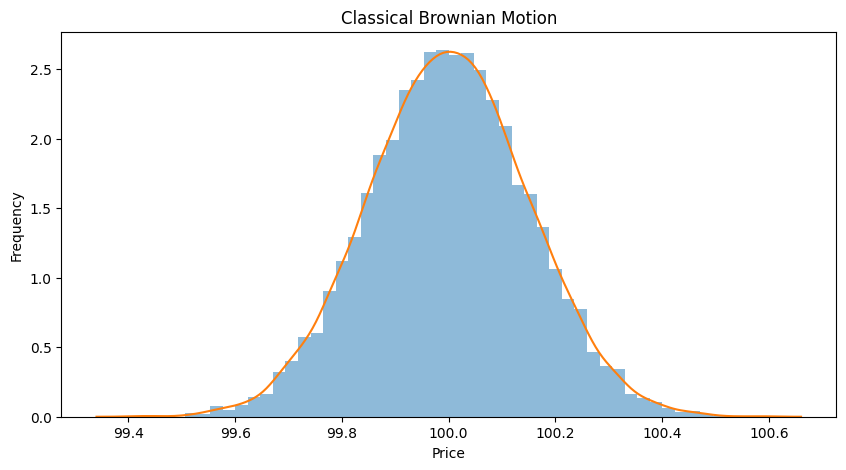

Type: Arithmetic_return_system
Expected Value:  99.9679602494736
Standard Deviation:  15.051183091949813
Estimated Value:  100
Estimated Standard Deviation:  100


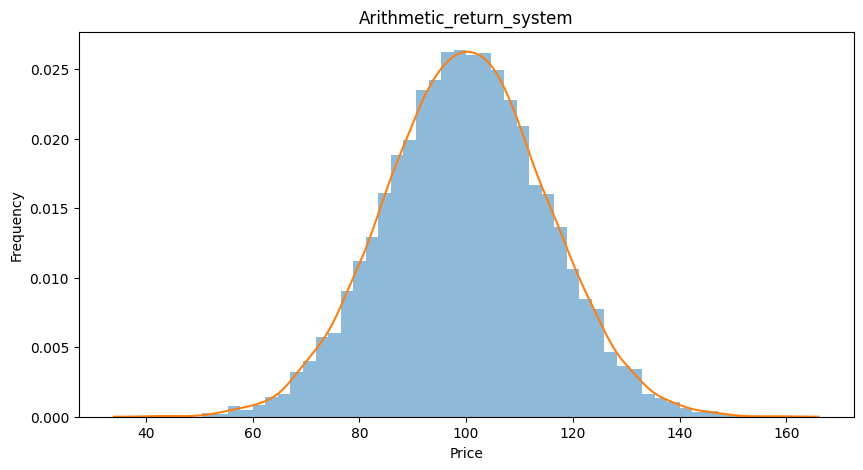

Type: Geometric Brownian Motion
Expected Value:  101.10689918789151
Standard Deviation:  15.309253511158992
Estimated Value:  101.13135192236113
Estimated Standard Deviation:  101.13135192236113


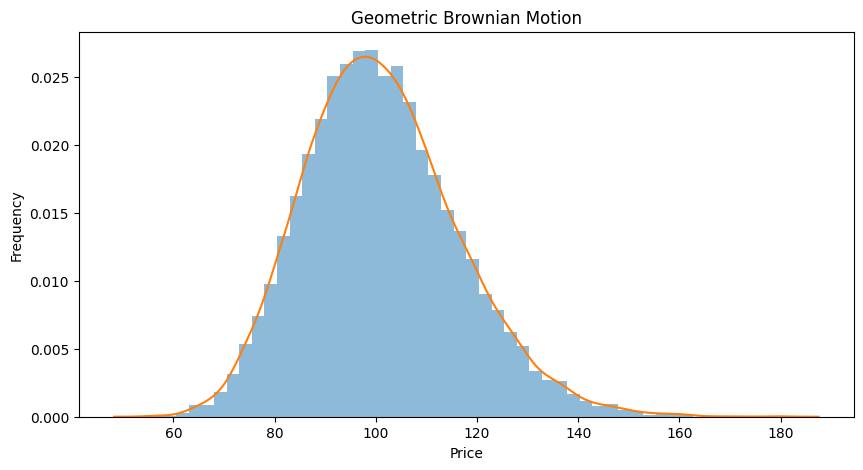

array([107.73530174,  97.94739421, 110.20292805, ...,  89.96067923,
       107.7199735 , 110.1483897 ])

In [5]:
P0 = 100
N = 10000
sigma = 0.15
mu = 0
simulate_classical_price(P0, N, sigma, mu)
simulate_arithmetic(P0, N, sigma, mu)
simulate_geometric(P0, N, sigma, mu)

## Problem 2

####  Implement return_calculate()

In [6]:
def return_calculate(prices, method="DISCRETE", dateColumn="Date"):
    StockName = prices.columns
    nVars = len(StockName)
    StockName = [var for var in StockName if var != dateColumn]
    if nVars == len(StockName):
        raise ValueError(f"dateColumn: {dateColumn} not in DataFrame: {vars_}")
    StockNumber = len(StockName)

    orgPrices = prices[StockName].to_numpy()
    time, stock = orgPrices.shape
    returns = np.empty((time-1, stock))

    for i in range(time-1):
        for j in range(stock):
            returns[i, j] = orgPrices[i+1, j] / orgPrices[i, j]

    if method.upper() == "DISCRETE":
        returns = returns - 1.0
    elif method.upper() == "LOG":
        returns = np.log(returns)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")

    dates = prices[dateColumn].iloc[1:time].to_numpy()
    out = pd.DataFrame({dateColumn: dates})
    for i in range(StockNumber):
        out[StockName[i]] = returns[:, i]

    return out

In [7]:
prices = pd.read_csv('DailyPrices.csv')
returns_all = return_calculate(prices)

/tmp/ipykernel_1288/3403899936.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[StockName[i]] = returns[:, i]
/tmp/ipykernel_1288/3403899936.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[StockName[i]] = returns[:, i]


### Calculate the VaR for META

In [8]:
meta = returns_all['META']-returns_all['META'].mean()

#### 1. Using a normal distribution

In [9]:
def calculate_var_normal(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a normal distribution"""
    mu = returns.mean()
    sigma = returns.std()
    sim_returns = np.random.normal(mu, sigma, num_simulations)
    var_normal = -np.percentile(sim_returns, alpha*100)
    return var_normal, sim_returns

#### 2.  Using a normal distribution with an Exponentially Weighted variance (λ = 0. 94)

In [10]:
def exp_weighted_cov(returns, lambda_=0.94):
    """
    Perform calculation on the input data set with a given λ for exponentially weighted covariance.
    
    Parameters:
    - data: input data set, a pandas DataFrame
    - lambda_: fraction for unpdate the covariance matri, default 0.97
    
    Returns:
    cov: an exponentially weighted covariance matrix, a numpy array
    """
    
    # Preprocess the data
    returns = returns.values
    mean_return = np.mean(returns, axis=0)
    normalized_returns = returns - mean_return
    
    # Initializing the variance
    n_timesteps = normalized_returns.shape[0]
    var = np.cov(returns, rowvar=False)
    
    # Updating the variance
    for t in range(1, n_timesteps):
        var = lambda_ * var + (1 - lambda_) * np.outer(normalized_returns[t], normalized_returns[t])
    return var


In [11]:
def calculate_var_ew_normal(returns, lambda_=0.94, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a normal distribution with exponentially weighted variance"""
    mu = returns.mean()
    sigma = np.sqrt(exp_weighted_cov(returns, lambda_=lambda_))
    sim_returns = np.random.normal(mu, sigma[0][0], num_simulations)
    var_ew = -np.percentile(sim_returns, alpha*100)
    return var_ew, sim_returns


#### 3. Using a MLE fitted T distribution

In [12]:
def MLE_T(params, returns):
    negLL = -1 * np.sum(t.logpdf(returns, df=params[0], loc=params[1], scale=params[2]))
    return(negLL)

In [13]:
def calculate_var_t_MLE(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a T-distribution with MLE fitted degrees of freedom"""
    constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, {"type":"ineq", "fun":lambda x: x[2]})
    returns_t = minimize(MLE_T, x0=[10, np.mean(returns), np.std(returns)], args=returns, constraints=constraints)
    df, loc, scale = returns_t.x[0], returns_t.x[1], returns_t.x[2]
    sim_returns = t.rvs(df, loc=loc, scale=scale, size=num_simulations)
    var_t = -np.percentile(sim_returns, alpha*100)
    return var_t, sim_returns

#### 4. Using a fitted AR(1) model

In [14]:
def calculate_var_ar1(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using an AR(1) model"""
    model = ARIMA(returns, order=(1, 0, 0)).fit()
    alpha_1 = model.params[0]
    beta = model.params[1]
    resid = model.resid
    sigma = np.std(resid)
    sim_returns = np.empty(num_simulations)
    returns = returns.values
    for i in range(num_simulations):
        sim_returns[i] =  beta * (returns[-1]) + sigma * np.random.normal()
    var_ar1 = -np.percentile(sim_returns, alpha*100)
    return var_ar1, sim_returns

#### 5. Using a Historic Simulation

In [15]:
def calculate_var_hist(returns, alpha=0.05):
    """Calculate VaR using historic simulation"""
    var_hist = -np.percentile(returns, alpha*100)
    return var_hist, returns

#### Calculate the VaR and Compare

In [16]:
def plot_histogram_with_var(series, var, title):
    """Plot the distribution for the series with the VaR marked on the figure"""
    plt.hist(series, bins=80, density=True, alpha=0.5)
    sns.kdeplot(series, color='g', linewidth=1)
    plt.axvline(-var, color='r', linestyle='--')
    plt.title(title + ' = {:.6f}'.format(var))
    plt.savefig(title, dpi =300)
    plt.show()

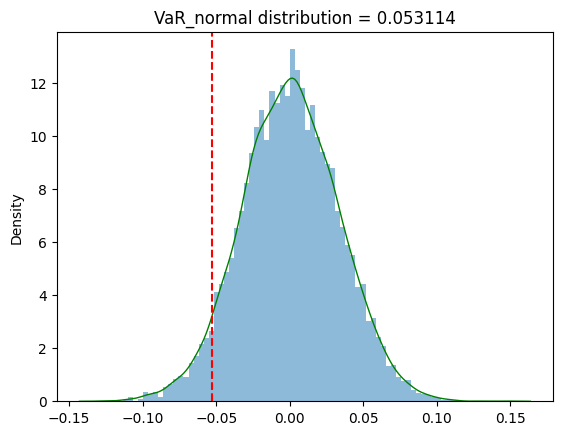

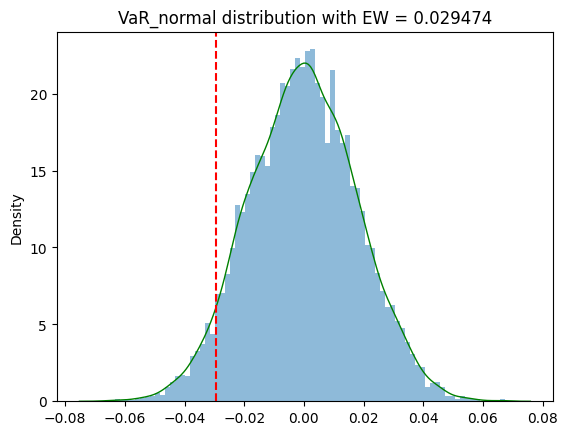

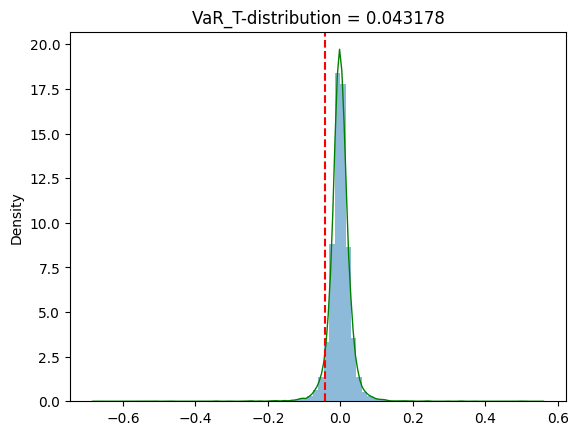

/tmp/ipykernel_1288/2257314252.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_1 = model.params[0]
/tmp/ipykernel_1288/2257314252.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


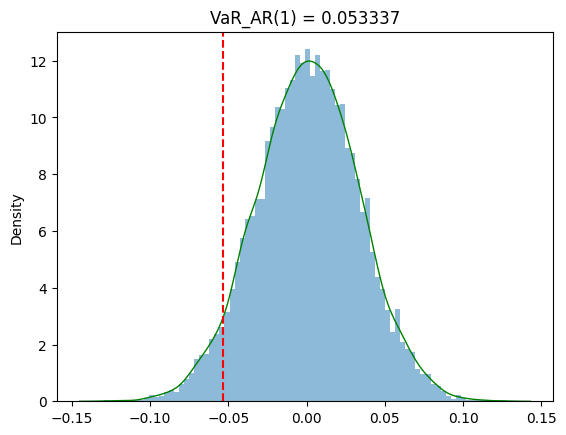

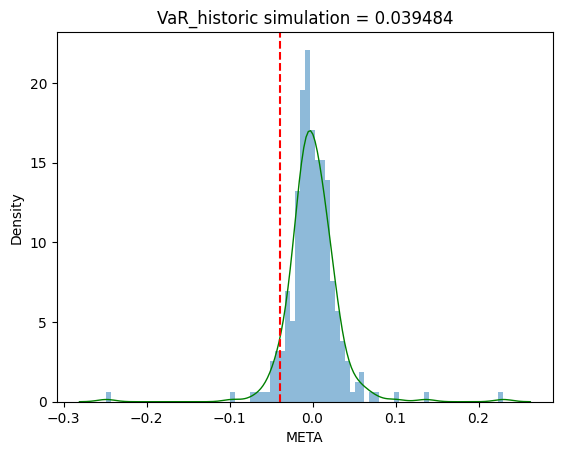

In [17]:
var_normal, returns_normal = calculate_var_normal(meta)
plot_histogram_with_var(returns_normal, var_normal, "VaR_normal distribution")

var_ew, returns_ew = calculate_var_ew_normal(meta)
plot_histogram_with_var(returns_ew, var_ew, "VaR_normal distribution with EW")

var_t, returns_t = calculate_var_t_MLE(meta)
plot_histogram_with_var(returns_t, var_t, "VaR_T-distribution")

var_ar1, returns_ar1 = calculate_var_ar1(meta)
plot_histogram_with_var(returns_ar1, var_ar1, "VaR_AR(1)")

var_hist, returns_hist = calculate_var_hist(meta)
plot_histogram_with_var(returns_hist, var_hist, "VaR_historic simulation")

In [18]:
print('VaR')
print('VaR (normal distribution) = {:.4f}' .format(var_normal))
print('VaR (normal distribution with EW) = {:.4f}' .format(var_ew))
print('VaR (T-distribution) = {:.4f}' .format(var_t))
print('VaR (AR(1)) = {:.4f}' .format(var_ar1))
print('VaR (historic simulation) = {:.4f}' .format(var_hist))

VaR
VaR (normal distribution) = 0.0531
VaR (normal distribution with EW) = 0.0295
VaR (T-distribution) = 0.0432
VaR (AR(1)) = 0.0533
VaR (historic simulation) = 0.0395


## Problem 3

In [19]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")

In [20]:
def get_portfolio_price(portfolio, prices, portfolio_code, Delta=False):
    """Get the price for each asset in portfolio and calculate the current price."""
    
    if portfolio_code == "All":
        assets = portfolio.drop('Portfolio',axis=1)
        assets = assets.groupby(["Stock"], as_index=False)["Holding"].sum()
    else:
        assets = portfolio[portfolio["Portfolio"] == portfolio_code]
        
    stock_codes = list(assets["Stock"])
    assets_prices = pd.concat([prices["Date"], prices[stock_codes]], axis=1)
    
    current_price = np.dot(prices[assets["Stock"]].tail(1), assets["Holding"])
    holdings = assets["Holding"]
    
    if Delta == True:
        asset_values = assets["Holding"].values.reshape(-1, 1) * prices[assets["Stock"]].tail(1).T.values
        delta = asset_values / current_price
        
        return current_price, assets_prices, delta
    
    return current_price, assets_prices, holdings


#### Calculate VaR with Delta Normal VaR method

In [68]:
def calculate_delta_var(portfolio, prices, alpha=0.05, lambda_=0.94, portfolio_code="All"):
    """
    Calculate delta VaR for a given portfolio using the Delta Normal VaR method.
    
    Parameters:
    - portfolio: a pandas DataFrame with columns 'Portfolio', 'Stock', and 'Holding'
    - prices: a pandas DataFrame with columns 'Date' and stock codes as column names
    - alpha: the significance level for VaR calculation, default 0.05
    - lambda_: fraction for update the covariance matrix, default 0.94
    - portfolio_code: a string for the specific portfolio to calculate, default "All"
    
    Returns:
    - current_value: current value for the specific portfolio
    - VaR: delta VaR for the portfolio in $
    """
    
    current_price, assets_prices, delta = get_portfolio_price(portfolio, prices, portfolio_code, Delta=True)

    returns = return_calculate(assets_prices).drop('Date', axis=1)
    assets_cov = exp_weighted_cov(returns, lambda_)

    p_sig = np.sqrt(np.transpose(delta) @ assets_cov @ delta)
    
    var_delta = -current_price * norm.ppf(alpha) * p_sig
    
    return current_price[0], var_delta[0][0]


#### Calculate VaR with Normal Monte Carlo simulation

In [69]:
def multivariate_normal_simulation(covariance_matrix, n_samples, explained_variance=1.0):

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Only consider eigenvalues greater than 0
        idx = eigenvalues > 1e-8
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Sort the eigenvalues in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Update the explained_variance incase the explained_variance is higher than the cumulative sum of the eigenvalue
        if explained_variance == 1.0:
            explained_variance = (np.cumsum(eigenvalues)/np.sum(eigenvalues))[-1]
        
        # Determine the number of components to keep based on the explained variance ratio
        n_components = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= explained_variance)[0][0] + 1
        eigenvectors = eigenvectors[:,:n_components]
        eigenvalues = eigenvalues[:n_components]

        normal_samples = np.random.normal(size=(n_components, n_samples))
        
        # Simulate the multivariate normal samples by multiplying the eigenvectors with the normal samples
        B = np.dot(eigenvectors, np.diag(np.sqrt(eigenvalues)))
        samples = np.transpose(np.dot(B, normal_samples))
        
        return samples

In [70]:
def calculate_MC_var(portfolio, prices, alpha=0.05, lambda_=0.94, n_simulation = 10000, portfolio_code="All"):
    """
    Calculate delta VaR for a given portfolio using the Delta Normal VaR method.
    
    Parameters:
    - portfolio: a pandas DataFrame with columns 'Portfolio', 'Stock', and 'Holding'
    - prices: a pandas DataFrame with columns 'Date' and stock codes as column names
    - alpha: the significance level for VaR calculation, default 0.05
    - lambda_: fraction for update the covariance matrix, default 0.94
    - portfolio_code: a string for the specific portfolio to calculate, default "All"
    
    Returns:
    - current_value: current value for the specific portfolio
    - VaR: delta VaR for the portfolio in $
    """
    
    current_price, assets_prices, holdings = get_portfolio_price(portfolio, prices, portfolio_code)
    
    returns = return_calculate(assets_prices).drop('Date',axis=1)
    returns_norm = returns - returns.mean()
    assets_cov = exp_weighted_cov(returns_norm, lambda_)
    
    assets_prices = assets_prices.drop('Date',axis=1)
    np.random.seed(0)
    sim_returns = np.add(multivariate_normal_simulation(assets_cov, n_simulation), returns.mean().values)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)
    
    var_MC = -np.percentile(sim_prices, alpha*100)
    
    return current_price[0], var_MC, sim_prices
    

#### Calculate VaR with Historical VaR

In [71]:
def calculate_historic_var(portfolio, prices, alpha=0.05,n_simulation=1000, portfolio_code="All"):
    """
    Calculate historical Value at Risk (VaR) for a given portfolio using exponentially weighted covariance.

    Parameters:
    - portfolio: a pandas DataFrame of the portfolio with columns "Portfolio", "Stock", "Holding"
    - prices: a pandas DataFrame of historical prices with columns "Date" and stock codes as other columns
    - alpha: a float between 0 and 1 for the confidence level, default 0.05
    - portfolio_code: a string for the specific portfolio to calculate, default "All"

    Returns:
    - historic_var: a float for the historical VaR in $
    """
    
    current_price, assets_prices, holdings = get_portfolio_price(portfolio, prices, portfolio_code)
    
    returns = return_calculate(assets_prices).drop("Date", axis=1)
    
    assets_prices = assets_prices.drop('Date',axis=1)
    sim_returns = returns.sample(n_simulation, replace=True)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)
    
    var_hist = -np.percentile(sim_prices, alpha*100)
    
    return current_price[0], var_hist, sim_prices

#### Calculate VaR for each portfolio and compare

For porfolio_A
The current value is: 1089316.16
VaR (Delta Normal) is: 15426.97
VaR (Monte Carlo) is: 14014.13
VaR (Historic) is: 17933.41



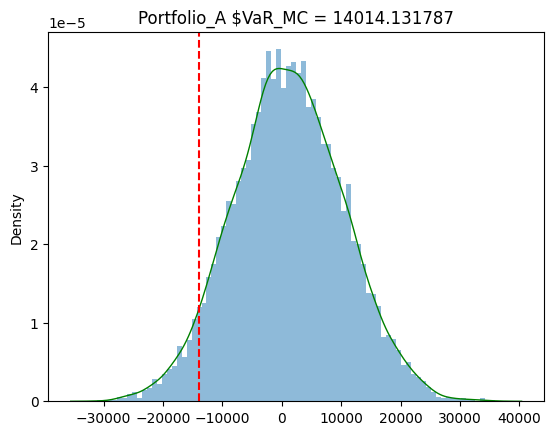

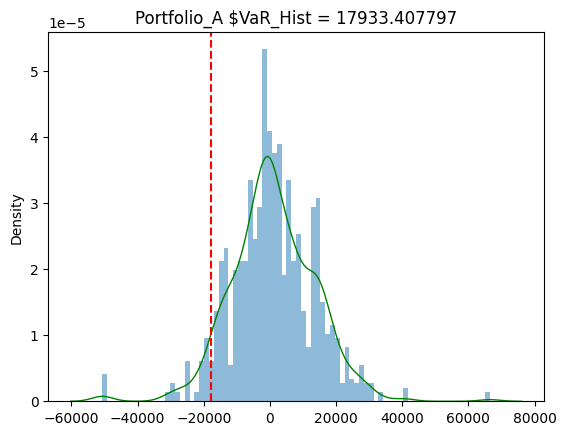

In [72]:
code = 'A'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_B
The current value is: 574542.41
VaR (Delta Normal) is: 8082.57
VaR (Monte Carlo) is: 7474.11
VaR (Historic) is: 10983.46



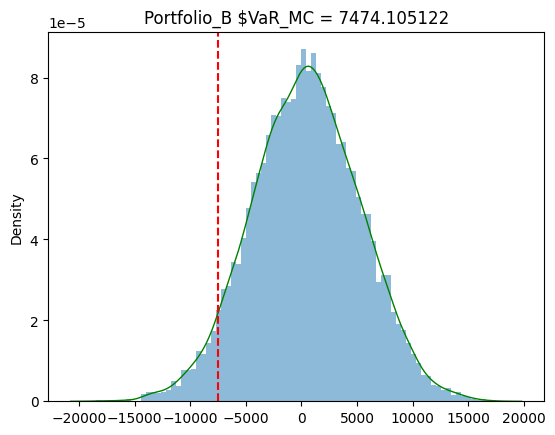

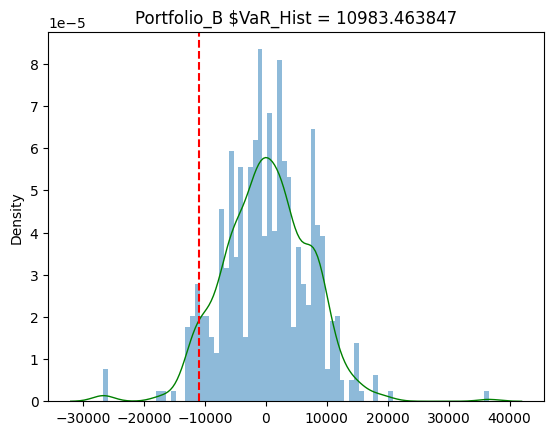

In [73]:
code = 'B'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_C
The current value is: 1387409.51
VaR (Delta Normal) is: 18163.29
VaR (Monte Carlo) is: 16285.41
VaR (Historic) is: 21409.75



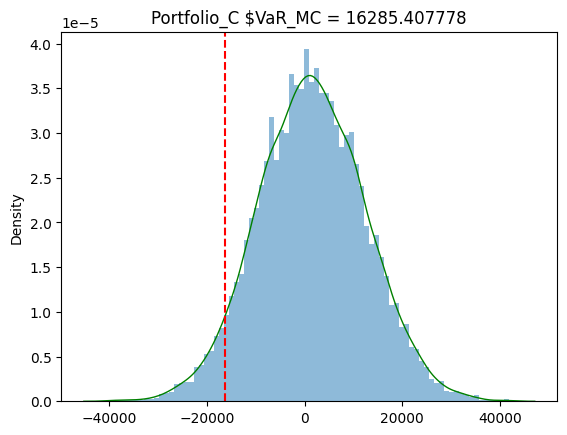

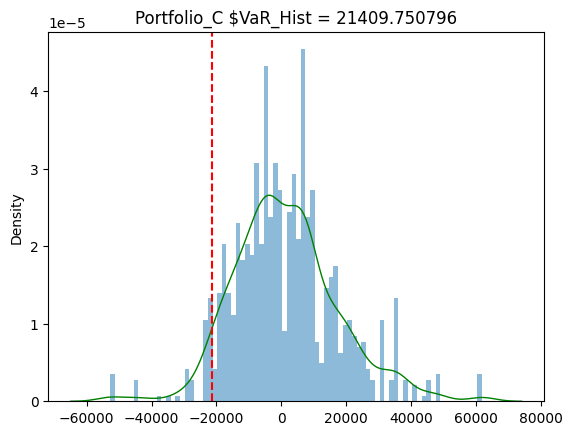

In [74]:
code = 'C'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))

For porfolio_All
The current value is: 3051268.07
VaR (Delta Normal) is: 38941.38
VaR (Monte Carlo) is: 35642.05
VaR (Historic) is: 49544.19



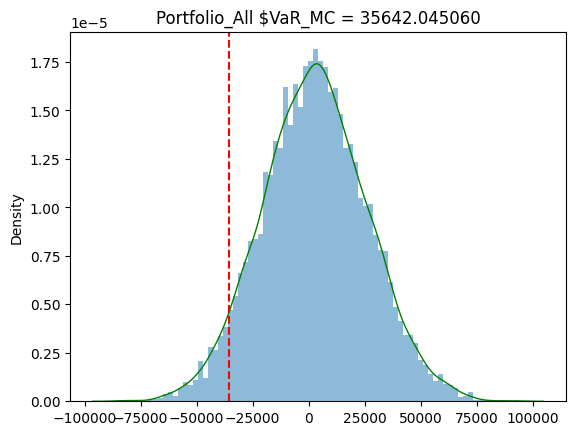

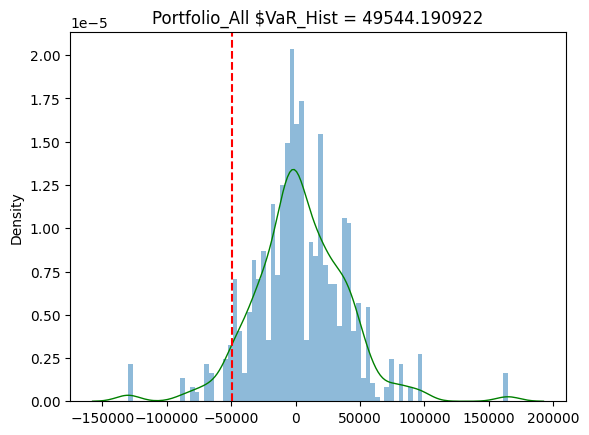

In [75]:
code = 'All'
current_price, delta_var = calculate_delta_var(portfolio, prices, portfolio_code=code)
current_price, mc_var, mc_sim_prices = calculate_MC_var(portfolio, prices, portfolio_code=code)
current_price, hist_var, hist_sim_prices = calculate_historic_var(portfolio, prices, portfolio_code=code)
print("For porfolio_{}".format(code))
print("The current value is: {:.2f}".format(current_price))
print("VaR (Delta Normal) is: {:.2f}".format(delta_var))
print("VaR (Monte Carlo) is: {:.2f}".format(mc_var))
print("VaR (Historic) is: {:.2f}\n".format(hist_var))
plot_histogram_with_var(mc_sim_prices, mc_var, "Portfolio_{} $VaR_MC".format(code))
plot_histogram_with_var(hist_sim_prices, hist_var, "Portfolio_{} $VaR_Hist".format(code))